# Here I use Indian Smoke data But Instead You use Any Location's IOT data of Forest for Smoke/Fi prediction

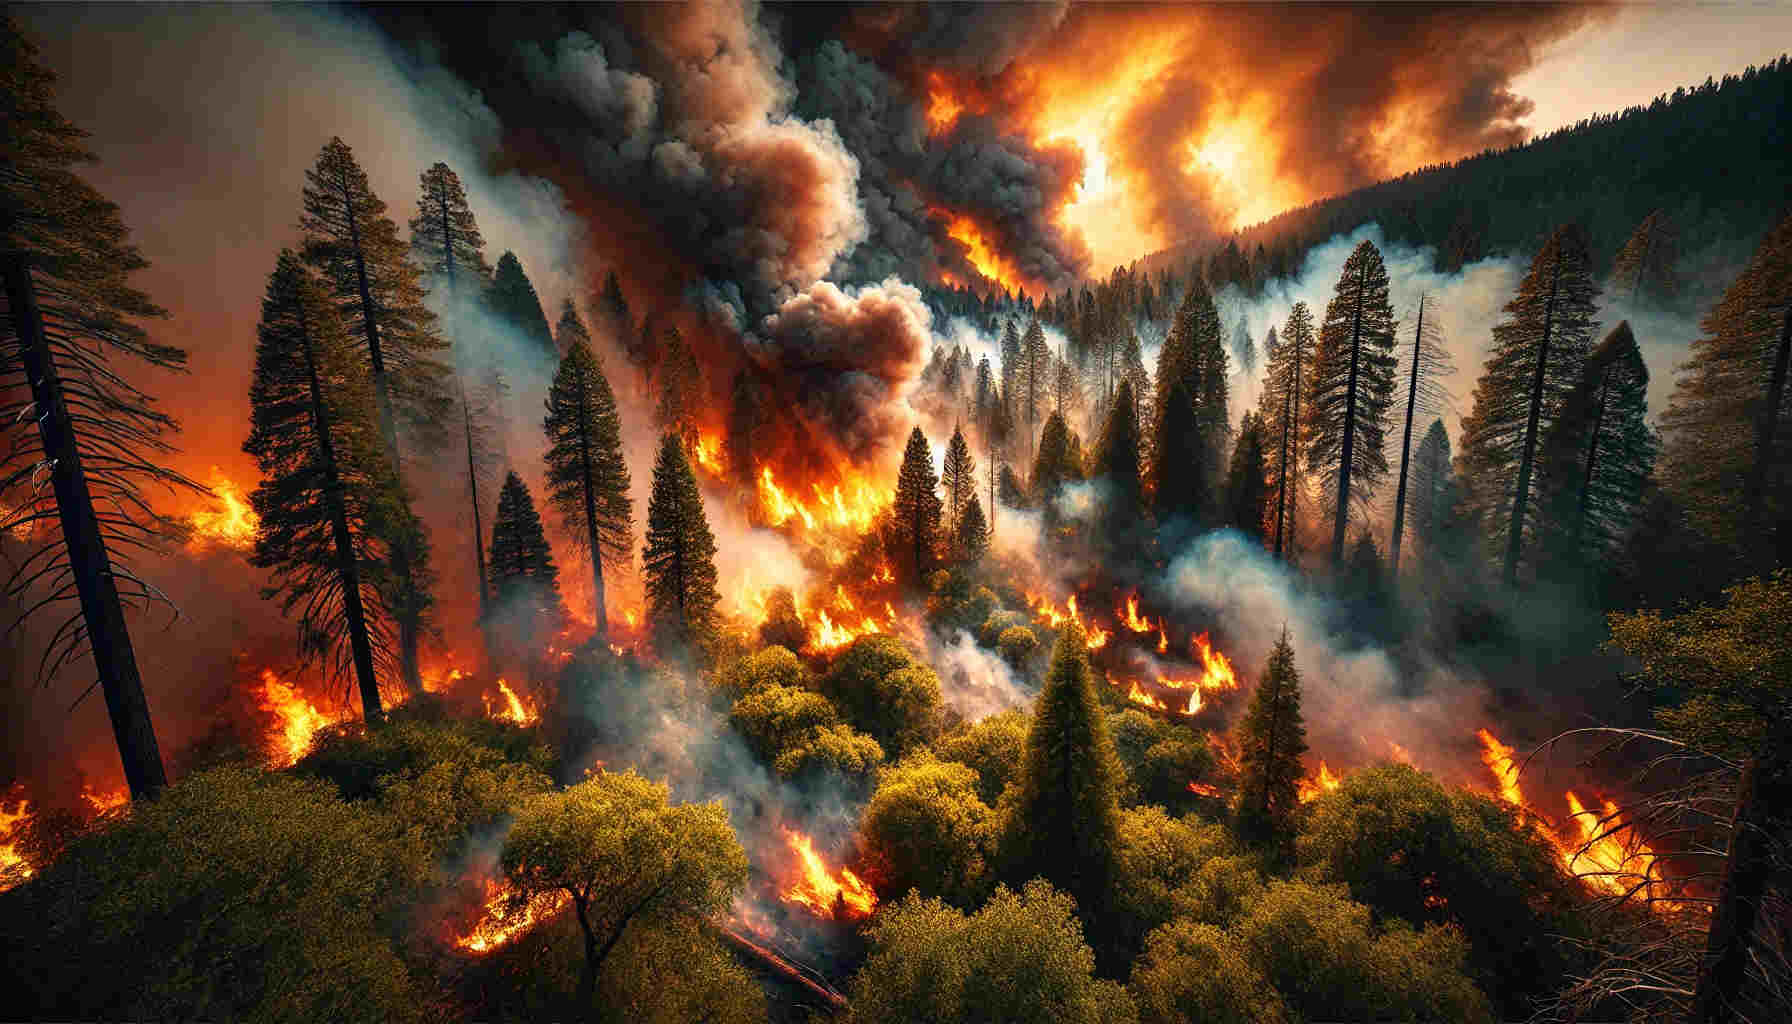

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indian-smoke-dataset-for-forest-fire/smoke_detection_india.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import lightgbm as lgb

import warnings

# Suppress warnings
warnings.filterwarnings("ignore")


<a id="dataset-analysis"></a>
# <p style="padding:10px;background-color:#2e3b4e;margin:0;color:#e8e8e8;font-family:Arial,sans-serif;font-size:110%;text-align:center;border-radius:10px;overflow:hidden;font-weight:600">Dataset Analysis</p>


# About Dataset

**Temperature[C]:** Indian range (20°C–45°C) with some missing values (NaN).

**Humidity[%]:** Indian range (20%–90%) with random NaNs.

**TVOC[ppb]:** Air pollution range (0–500 ppb).

**eCO2[ppm]:** CO2 range (400–2000 ppm).

Raw H2, Raw Ethanol, Pressure[hPa], and particulate matter columns (PM1.0, PM2.5).

**Fire Alarm:** Binary indicator for smoke detection.

In [3]:
data = pd.read_csv('/kaggle/input/indian-smoke-dataset-for-forest-fire/smoke_detection_india.csv')

In [4]:
data.head(20).style.set_properties(**{
    "background-color": "aqua", 
    "color": "#000000", 
    "border": "1.5px solid #5f0d11"
})


,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,1654733331,26.530537,65.536648,148.019614,872.133377,12306,18520,939.735000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
1,1,1654733332,34.857769,28.617763,228.726014,973.713705,12345,18651,939.744000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0
2,2,1654733333,35.418868,54.643717,453.817698,1853.552569,12374,18764,939.738000,0.000000,0.000000,0.000000,0.000000,0.000000,2,0
3,3,1654733334,38.977190,81.335893,384.933268,1166.980106,12390,18849,939.736000,0.000000,0.000000,0.000000,0.000000,0.000000,3,0
4,4,1654733335,44.673993,31.288192,172.124316,1318.026987,12403,18921,939.744000,0.000000,0.000000,0.000000,0.000000,0.000000,4,0
5,5,1654733336,39.870454,64.384805,171.291409,1723.643983,12419,18998,939.725000,0.000000,0.000000,0.000000,0.000000,0.000000,5,0
6,6,1654733337,38.948572,46.482374,239.567872,1540.322611,12432,19058,939.738000,0.000000,0.000000,0.000000,0.000000,0.000000,6,0
7,7,1654733338,29.993223,87.181905,171.747667,603.540072,12439,19114,939.758000,0.000000,0.000000,0.000000,0.000000,0.000000,7,0
8,8,1654733339,29.402637,77.655012,87.384855,1615.849921,12448,19155,939.758000,0.000000,0.000000,0.000000,0.000000,0.000000,8,0
9,9,1654733340,40.972443,39.755337,58.440488,1446.464142,12453,19195,939.756000,0.900000,3.780000,0.000000,4.369000,2.780000,9,0


In [5]:
data.describe().style.set_properties(**{
    "background-color": "aqua", 
    "color": "#000000", 
    "border": "1.5px solid #5f0d11"
})


,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
count,62630.000000,62630.000000,56367.000000,56367.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000
mean,31314.500000,1654792066.184273,32.516938,54.993921,249.664705,1198.667047,12942.453936,19754.257912,938.627649,100.594309,184.467770,491.463608,203.586487,80.049042,10511.386157,0.714626
std,18079.868017,110002.488078,7.236683,20.194001,144.505688,461.101112,272.464305,609.513156,1.331344,922.524245,1976.305615,4265.661251,2214.738556,1083.383189,7597.870997,0.451596
min,0.000000,1654712187.000000,20.000377,20.001490,0.000072,400.002467,10668.000000,15317.000000,930.852000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15657.250000,1654743244.250000,26.234673,37.489944,124.505288,800.317301,12830.000000,19435.000000,938.700000,1.280000,1.340000,8.820000,1.384000,0.033000,3625.250000,0.000000
50%,31314.500000,1654761919.500000,32.509742,54.992853,249.837629,1196.110752,12924.000000,19501.000000,938.816000,1.810000,1.880000,12.450000,1.943000,0.044000,9336.000000,1.000000
75%,46971.750000,1654777576.750000,38.828024,72.430315,375.137121,1596.928116,13109.000000,20078.000000,939.418000,2.090000,2.180000,14.420000,2.249000,0.051000,17164.750000,1.000000
max,62629.000000,1655130051.000000,44.998674,89.999837,499.995902,1999.934592,13803.000000,21410.000000,939.861000,14333.690000,45432.260000,61482.030000,51914.680000,30026.438000,24993.000000,1.000000


In [6]:
data.duplicated().sum()


0

In [7]:
print("Null value in every column is :")
null_count = data.isnull().sum()

# Convert the Series to a DataFrame to apply style
null_count_df = null_count.to_frame()

# Apply styling to the DataFrame
null_count_df.style.set_properties(**{
    "background-color": "aqua", 
    "color": "black",  
    "border": "1.5px solid #5f0d11"
})


Null value in every column is :


,0
Unnamed: 0,0
UTC,0
Temperature[C],6263
Humidity[%],6263
TVOC[ppb],0
eCO2[ppm],0
Raw H2,0
Raw Ethanol,0
Pressure[hPa],0
PM1.0,0


In [8]:
data.columns

Index(['Unnamed: 0', 'UTC', 'Temperature[C]', 'Humidity[%]', 'TVOC[ppb]',
       'eCO2[ppm]', 'Raw H2', 'Raw Ethanol', 'Pressure[hPa]', 'PM1.0', 'PM2.5',
       'NC0.5', 'NC1.0', 'NC2.5', 'CNT', 'Fire Alarm'],
      dtype='object')

In [9]:
data=data.drop(columns=['Unnamed: 0'])

# Rename Column Name

In [10]:
# data["Fire Alarm"].replace({0:"No", 1:"Yes"}, inplace = True)
data.rename(columns={"Temperature[C]": "Temperature","Humidity[%]": "Humidity","TVOC[ppb]":"TVOC","eCO2[ppm]":"eCO2","Pressure[hPa]":"Pressure"}, inplace = True)
data = data[["Temperature","Humidity","TVOC","eCO2","Raw H2","Raw Ethanol","Pressure","PM1.0","PM2.5","NC0.5","NC1.0","NC2.5","Fire Alarm"]]
data.head().style.set_properties(**{
    "background-color": "aqua", 
    "color": "#000000", 
    "border": "1.5px solid #5f0d11"
})


,Temperature,Humidity,TVOC,eCO2,Raw H2,Raw Ethanol,Pressure,PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm
0,26.530537,65.536648,148.019614,872.133377,12306,18520,939.735000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,34.857769,28.617763,228.726014,973.713705,12345,18651,939.744000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,35.418868,54.643717,453.817698,1853.552569,12374,18764,939.738000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,38.977190,81.335893,384.933268,1166.980106,12390,18849,939.736000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,44.673993,31.288192,172.124316,1318.026987,12403,18921,939.744000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [11]:
data.columns

Index(['Temperature', 'Humidity', 'TVOC', 'eCO2', 'Raw H2', 'Raw Ethanol',
       'Pressure', 'PM1.0', 'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5', 'Fire Alarm'],
      dtype='object')

In [12]:
print("Data rows --->",data.shape[0],"no's")
print("Data columns -->",data.shape[1],"no's")


Data rows ---> 62630 no's
Data columns --> 13 no's


In [13]:
data.nunique().to_frame().T.style.set_properties(**{
    "background-color": "aqua", 
    "color": "black",  
    "border": "1.5px solid #5f0d11"
})


,Temperature,Humidity,TVOC,eCO2,Raw H2,Raw Ethanol,Pressure,PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm
0,56367,56367,62630,62630,1830,2659,2213,1337,1351,3093,4113,1161,2


<a id="dataset-analysis"></a>
# <p style="padding:10px;background-color:#2e3b4e;margin:0;color:#e8e8e8;font-family:Arial,sans-serif;font-size:110%;text-align:center;border-radius:10px;overflow:hidden;font-weight:600">EDA : Distribution Plot</p>


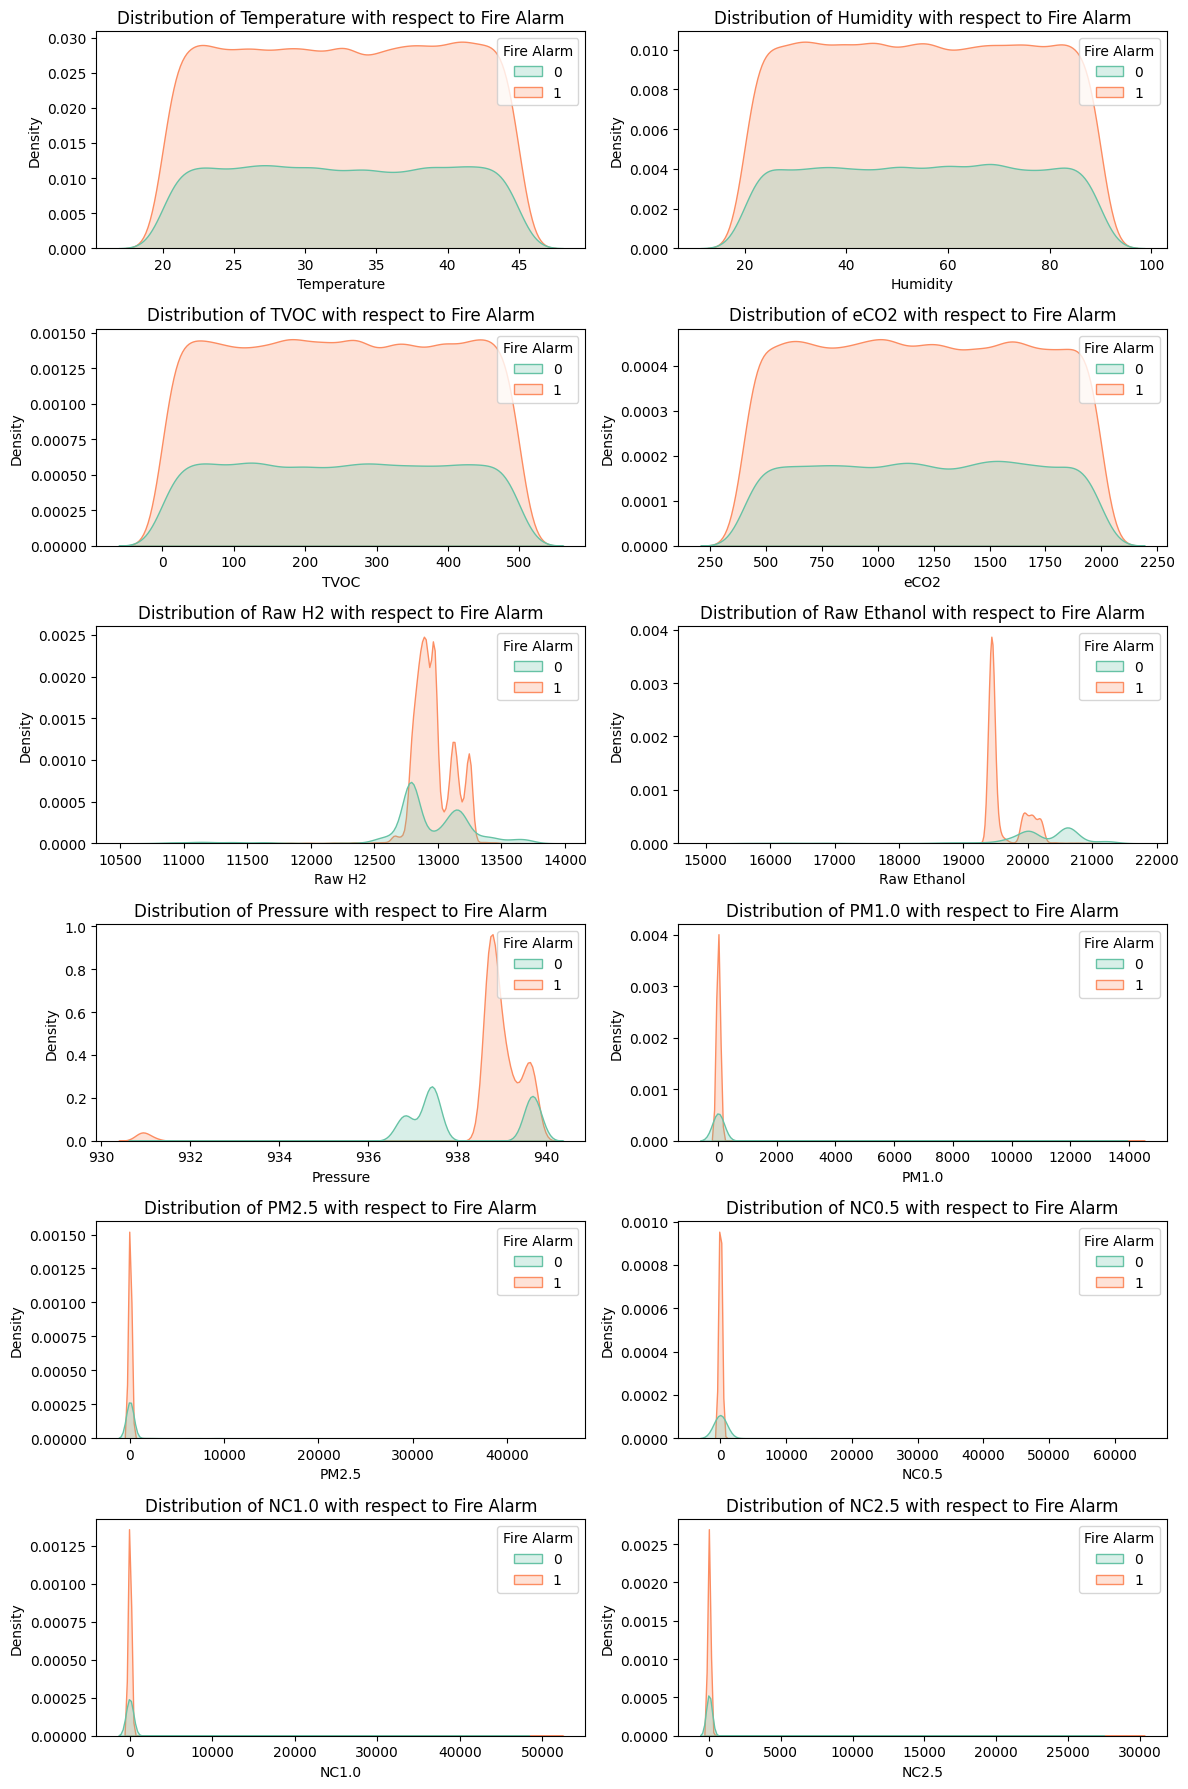

In [14]:
columns_to_plot = ['Temperature', 'Humidity', 'TVOC', 'eCO2', 'Raw H2', 'Raw Ethanol',
                   'Pressure', 'PM1.0', 'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5']

plt.figure(figsize=(12, 18))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(6, 2, i)  # Adjusted to (6, 2) grid for 2 plots per row
    sns.kdeplot(data=data, x=column, hue='Fire Alarm', fill=True, palette="Set2")
    plt.title(f'Distribution of {column} with respect to Fire Alarm')

# Adjust the layout
plt.tight_layout()
plt.show()


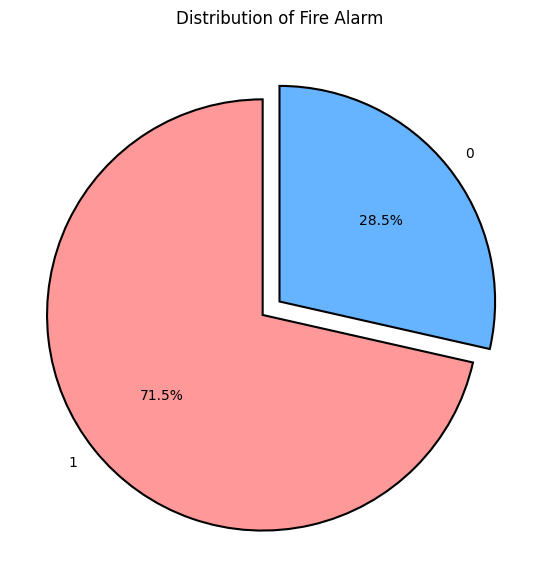

In [15]:
fire_alarm_counts = data["Fire Alarm"].value_counts()

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(fire_alarm_counts, labels=fire_alarm_counts.index, autopct='%1.1f%%', startangle=90, 
        colors=['#ff9999', '#66b3ff'], explode=(0.1, 0), wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
plt.title('Distribution of Fire Alarm')
plt.show()


<a id="dataset-analysis"></a>
# <p style="padding:10px;background-color:#2e3b4e;margin:0;color:#e8e8e8;font-family:Arial,sans-serif;font-size:110%;text-align:center;border-radius:10px;overflow:hidden;font-weight:600">Encoding</p>


In [16]:
# Label Encoding for categorical columns
catcol = [col for col in data.columns if data[col].dtype == "object"]
le = LabelEncoder()
for col in catcol:
    data[col] = le.fit_transform(data[col])

<a id="dataset-analysis"></a>
# <p style="padding:10px;background-color:#2e3b4e;margin:0;color:#e8e8e8;font-family:Arial,sans-serif;font-size:110%;text-align:center;border-radius:10px;overflow:hidden;font-weight:600">HeatMap</p>


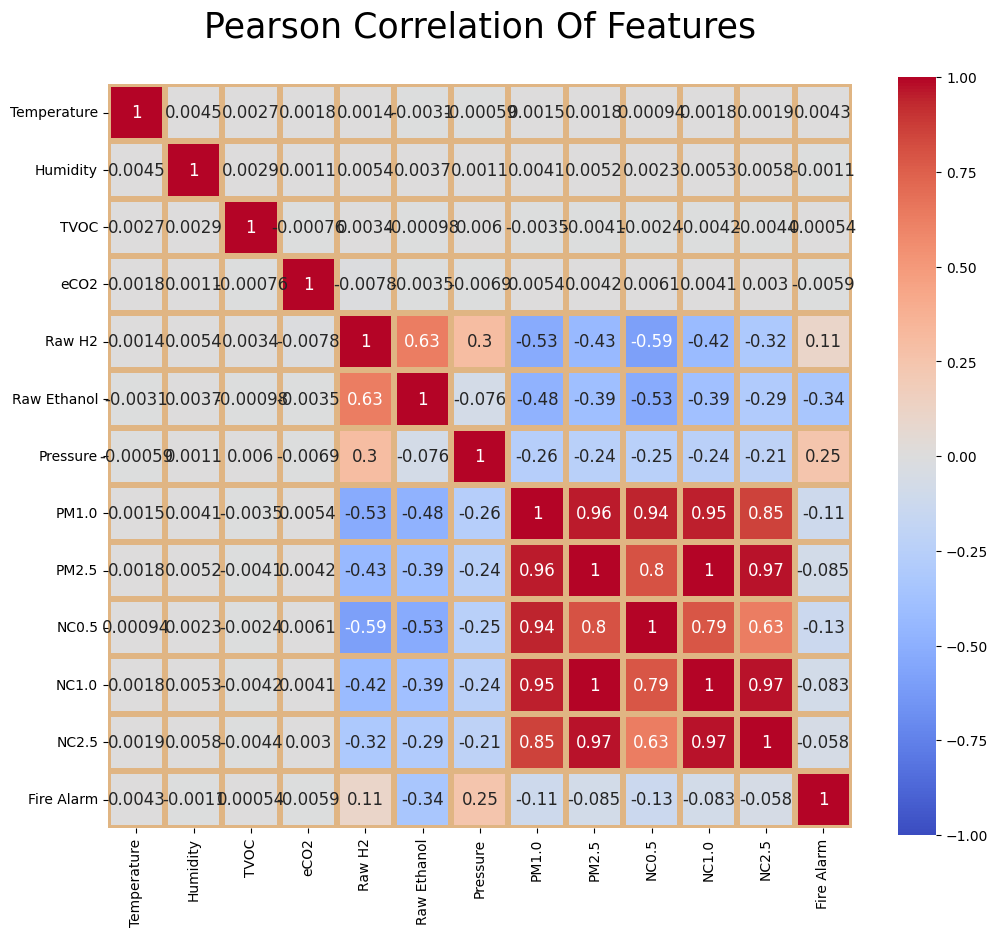

In [17]:
# Plotting the heatmap
plt.subplots(figsize=(12, 12))

# Create the heatmap with a valid colormap
sns.heatmap(data.corr(), cmap='coolwarm', square=True, cbar_kws=dict(shrink=0.82), 
            annot=True, vmin=-1, vmax=1, linewidths=3, linecolor='#e0b583', annot_kws=dict(fontsize=12))

# Title and axis settings
plt.title("Pearson Correlation Of Features\n", fontsize=25)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Show the plot
plt.show()


The heatmap shows **Pearson correlation coefficients** between features in the dataset:

1. **Red**: Strong positive correlation (e.g., `PM1.0` and `PM2.5`).
2. **Blue**: Strong negative correlation.
3. **`Fire Alarm`**: Positively correlated with particulate matter (`PM1.0`, `PM2.5`), indicating these influence alarm activation.
4. **Diagonal**: Correlation of features with themselves (
5. Temperature and Humidity have weak correlations with most features, meaning they may act independently.
6. Raw Ethanol and Raw H2 are positively correlated, indicating these gases often increase together.`edundancy.

<a id="dataset-analysis"></a>
# <p style="padding:10px;background-color:#2e3b4e;margin:0;color:#e8e8e8;font-family:Arial,sans-serif;font-size:110%;text-align:center;border-radius:10px;overflow:hidden;font-weight:600">Model Creation & Performance Evaluation</p>


In [18]:
x = data.drop(["Fire Alarm"],axis =1)
y = data["Fire Alarm"]
x.head()

,Temperature,Humidity,TVOC,eCO2,Raw H2,Raw Ethanol,Pressure,PM1.0,PM2.5,NC0.5,NC1.0,NC2.5
0,26.530537,65.536648,148.019614,872.133377,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0
1,34.857769,28.617763,228.726014,973.713705,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0
2,35.418868,54.643717,453.817698,1853.552569,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0
3,38.977190,81.335893,384.933268,1166.980106,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0
4,44.673993,31.288192,172.124316,1318.026987,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0


# Still High Vlue So We Apply Scaling

In [19]:
sc = StandardScaler()
x = sc.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(f"Shape of training data : {x_train.shape}, {y_train.shape}")
print(f"Shape of testing data : {x_test.shape}, {y_test.shape}")

Shape of training data : (50104, 12), (50104,)
Shape of testing data : (12526, 12), (12526,)


<a id="dataset-analysis"></a>
# <p style="padding:10px;background-color:#2e3b4e;margin:0;color:#e8e8e8;font-family:Arial,sans-serif;font-size:110%;text-align:center;border-radius:10px;overflow:hidden;font-weight:600">Lazy Predict : 29 Model Evaluation</p>


In [20]:
!pip install lazypredict


In [21]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0,
                     ignore_warnings=True,
                     custom_metric=None,
                     predictions=False,
                     random_state=2024,
                     classifiers='all')

models, predictions = clf.fit(x_train[:100_00] , x_test[:100_00] , y_train[:100_00] , y_test[:100_00])

 97%|█████████▋| 28/29 [00:35<00:00,  1.32it/s]

[LightGBM] [Info] Number of positive: 7121, number of negative: 2879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2982
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.712100 -> initscore=0.905605
[LightGBM] [Info] Start training from score 0.905605


100%|██████████| 29/29 [00:35<00:00,  1.22s/it]


In [22]:
models[:29]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.99,0.99,0.99,0.99,0.33
XGBClassifier,0.99,0.99,0.99,0.99,0.30
RandomForestClassifier,0.99,0.99,0.99,0.99,1.90
ExtraTreesClassifier,0.99,0.99,0.99,0.99,0.71
BaggingClassifier,0.99,0.99,0.99,0.99,0.43
DecisionTreeClassifier,0.99,0.99,0.99,0.99,0.09
AdaBoostClassifier,0.99,0.98,0.98,0.99,0.94
ExtraTreeClassifier,0.98,0.97,0.97,0.98,0.03
SVC,0.93,0.88,0.88,0.92,2.76


In [23]:
best_model = models.sort_values(by='F1 Score', ascending=False).iloc[:1]

# style
styled_best_model = best_model.style.set_properties(**{
    'background-color': '#d0f0c0',
    'color': '#333333',
    'border': '1px solid black',
}).set_table_styles([{
    'selector': 'thead th',
    'props': [('background-color', '#6c7ae0'),
              ('color', 'white'), 
              ('font-weight', 'bold')]
}])

styled_best_model


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.993300,0.991352,0.991352,0.993297,0.328151


<a id="dataset-analysis"></a>
# <p style="padding:10px;background-color:#2e3b4e;margin:0;color:#e8e8e8;font-family:Arial,sans-serif;font-size:110%;text-align:center;border-radius:10px;overflow:hidden;font-weight:600">Applying Light_GBM</p>


In [24]:
lgbm = lgb.LGBMClassifier(random_state=42)
lgbm.fit(x_train, y_train)
y_pred = lgbm.predict(x_test)

[LightGBM] [Info] Number of positive: 35825, number of negative: 14279
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 50104, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.715013 -> initscore=0.919856
[LightGBM] [Info] Start training from score 0.919856


In [25]:
train_accuracy = accuracy_score(y_train, lgbm.predict(x_train))
test_accuracy = accuracy_score(y_test, lgbm.predict(x_test))

print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, lgbm.predict(x_test)))

Train Accuracy: 1.00
Test Accuracy: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3594
           1       1.00      1.00      1.00      8932

    accuracy                           1.00     12526
   macro avg       1.00      1.00      1.00     12526
weighted avg       1.00      1.00      1.00     12526



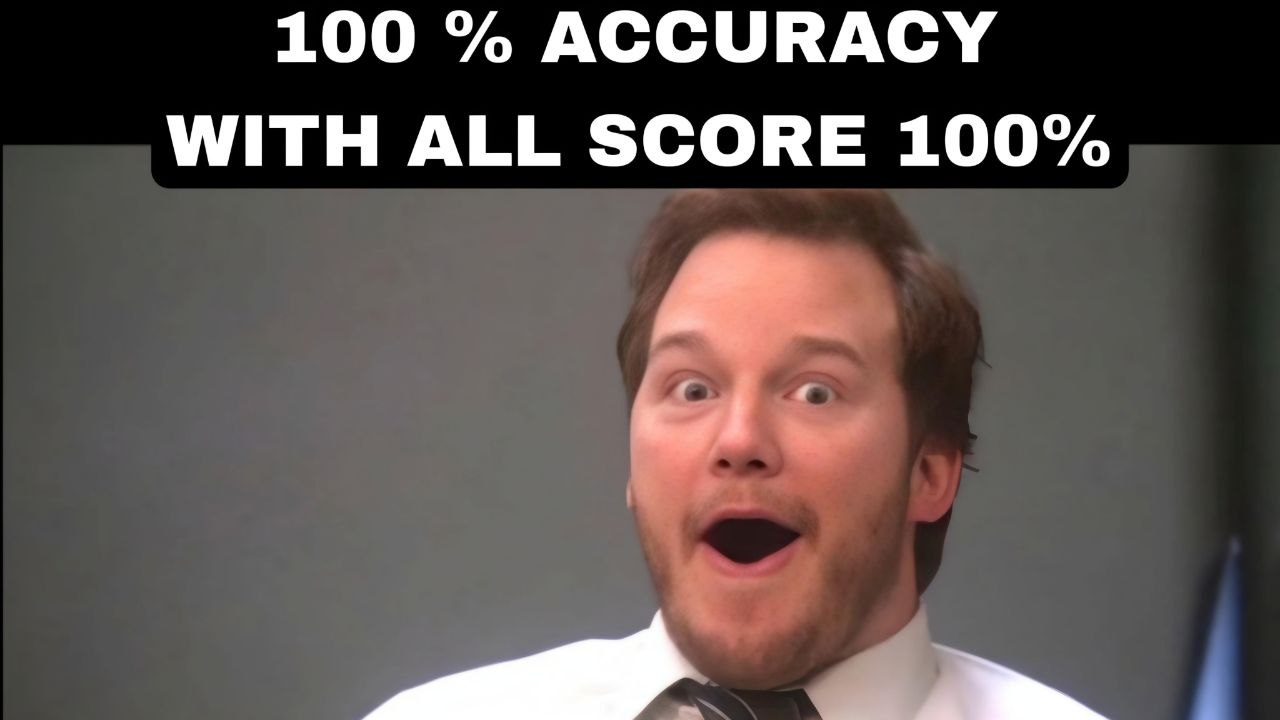

<a id="dataset-analysis"></a>
# <p style="padding:10px;background-color:#2e3b4e;margin:0;color:#e8e8e8;font-family:Arial,sans-serif;font-size:110%;text-align:center;border-radius:10px;overflow:hidden;font-weight:600">Visualize Train_Test Accuracy</p>


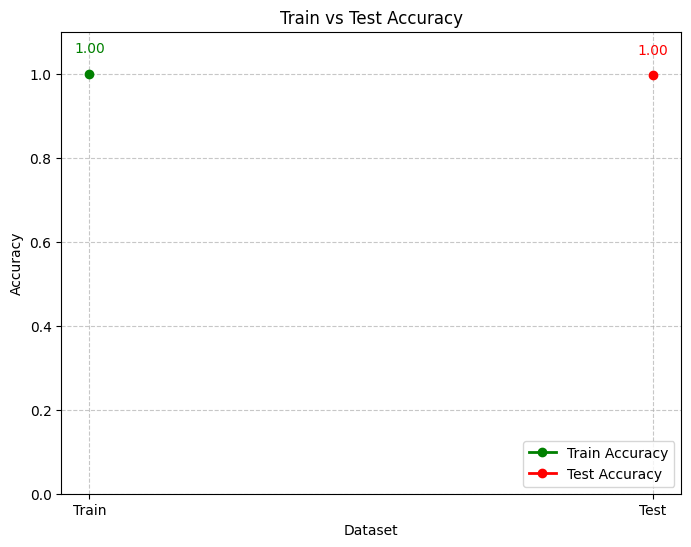

In [26]:

plt.figure(figsize=(8, 6))

# Plot train accuracy
plt.plot(['Train', 'Test'], [train_accuracy, None], marker='o', color='green', label='Train Accuracy', linewidth=2)
# Plot test accuracy
plt.plot(['Train', 'Test'], [None, test_accuracy], marker='o', color='red', label='Test Accuracy', linewidth=2)

plt.ylim(0, 1.1)
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.text(0, train_accuracy + 0.05, f'{train_accuracy:.2f}', ha='center', color='green')
plt.text(1, test_accuracy + 0.05, f'{test_accuracy:.2f}', ha='center', color='red')
plt.legend(loc='lower right')
plt.show()

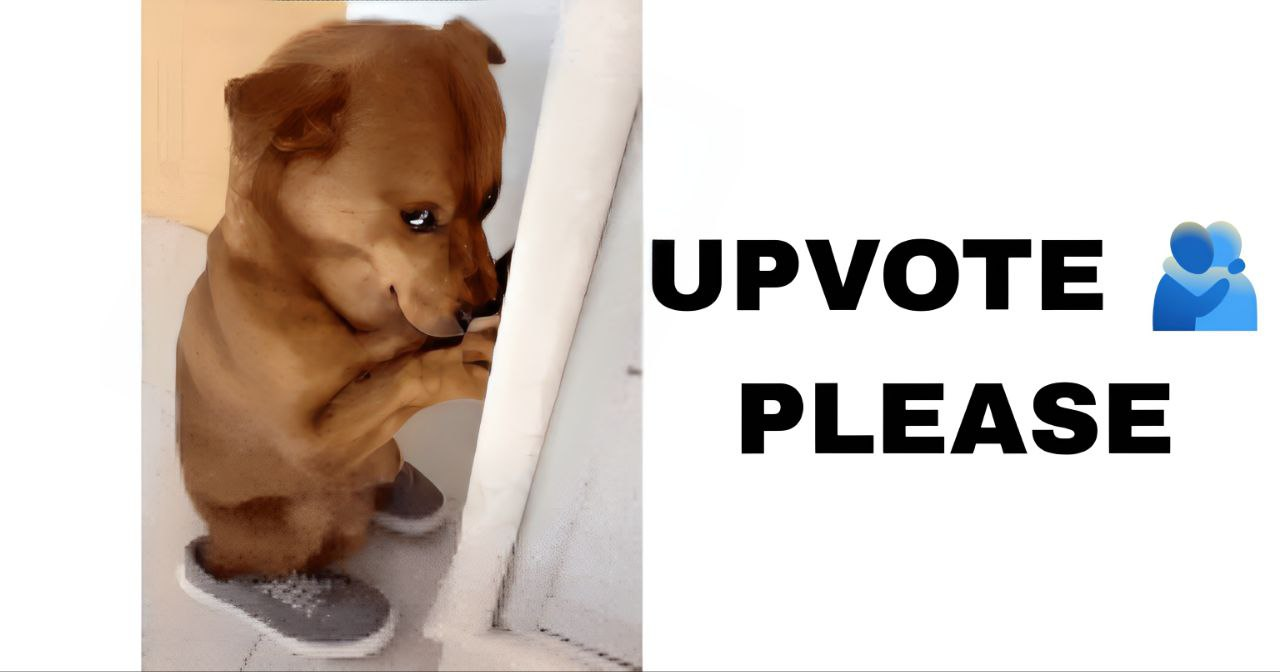